In [1]:
import pandas as pd
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# Confirmed data
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(confirmed_url)
print(df.head(5))

  Province/State Country/Region       Lat  ...  7/25/20  7/26/20  7/27/20
0            NaN    Afghanistan  33.93911  ...    36036    36157    36263
1            NaN        Albania  41.15330  ...     4637     4763     4880
2            NaN        Algeria  28.03390  ...    26764    27357    27973
3            NaN        Andorra  42.50630  ...      897      897      907
4            NaN         Angola -11.20270  ...      916      932      950

[5 rows x 192 columns]


In [2]:
def genCountryConfirmed(df, countryName):
  country = df.loc[lambda df: df['Country/Region'] == countryName, :]
  country_t = country.T
  noOfCols = len(country_t.columns)
  # header = [x for x in range(noOfCols)]
  # country_t.columns = header
  country_t = country_t[4:]
  country_sum = country_t.sum(axis = 1, skipna = True).to_frame()
  country_sum.columns = ['confirmed']
  return country_sum



Last 5:  [1.0383, 1.0398, 1.038, 1.0364, 1.0361]
Mean:  1.0986376344086022
Standard Deviation:  0.349549321027753


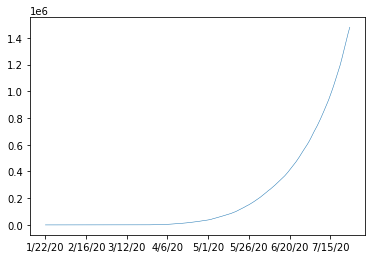

In [3]:
# import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(11, 4)})

india = genCountryConfirmed(df, 'India')
india['confirmed'].plot(linewidth=0.5);

def growthFactor(countryDf):
  factors = []
  cases = []
  for index, row in countryDf.iterrows():
    cases.append(row['confirmed'])
  for i in range(1, len(cases)-1):
    if(cases[i-1] == 0.0):
      factors.append(1.0)
      continue
    else:
      factors.append(round(cases[i]/cases[i-1], 4)) 
  print("Last 5: ", factors[-5:])
  print("Mean: ", np.mean(factors))
  print("Standard Deviation: ", np.std(factors))

growthFactor(india)


Estimation of the infection rate, Beta - This is only for demo

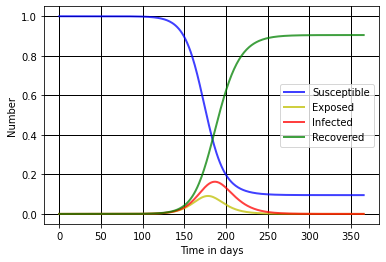

In [4]:
# Total population (India)
N = 1339.2E6

# 0.01 < p < 0.1
p = 309/N

E0 = 0
I0 = p*N
R0 = 0

S0 = N - E0 - I0 - R0

'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
beta, gamma, epsilon = 0.26, 0.1, 0.2

# No. of days
t = np.linspace(0, 365, 365)

def deriv(y, t, N, beta, gamma, epsilon):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = (beta * S * I / N) - (epsilon * E)
    dIdt = (epsilon * E) - (gamma * I)
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, epsilon))
S, E, I, R = ret.T

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='white', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.75, lw=2, label='Susceptible')
ax.plot(t, E/N, 'y', alpha=0.75, lw=2, label='Exposed')
ax.plot(t, I/N, 'r', alpha=0.75, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.75, lw=2, label='Recovered')
ax.set_xlabel('Time in days')
ax.set_ylabel('Number')
ax.grid(b=True, which='major', c='black', lw=1, ls='-')
ax.legend()
plt.show()

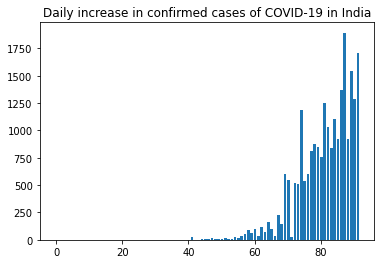

In [5]:
def newCases(countryDf):
  factors = []
  cases = []
  for index, row in countryDf.iterrows():
    cases.append(row['confirmed'])
  for i in range(1, len(cases)-1):
      factors.append(cases[i]-cases[i-1]) 
  return factors

t = np.linspace(0, 365, 365)
n_cases = newCases(india)[:92]
n_cases_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 23.0, 2.0, 1.0, 3.0, 5.0, 4.0, 13.0, 6.0, 11.0, 9.0, 20.0, 11.0, 6.0, 23.0, 14.0, 38.0, 50.0, 86.0, 66.0]
plt.title("Daily increase in confirmed cases of COVID-19 in India")
plt.bar(t[0:len(n_cases)], n_cases)
plt.show()

In [6]:
# Total population (India)
N = 1339.2E6

# 0.01 < p < 0.1
p = 0.01

E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

# No. of days
t = np.linspace(0, 120, 120)

def deriv(y, t, beta, gamma, epsilon):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = (beta * S * I) - (epsilon * E)
    dIdt = (epsilon * E) - (gamma * I)
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0

def j(n_cases, cmu_cap):
  sumOfDays = 0.0
  for x, y in zip(n_cases, cmu_cap):
    sumOfDays += (x-y)**2
  return sumOfDays

def infection_rate(n_cases):
  list_j = []
  beta_dist = []
  # t = np.linspace(0, len(n_cases), len(n_cases))
  t = np.array([x for x in range(len(n_cases))])

  for _ in range(10):
    # mu_cap calculation
    start, end, step = 0.20, 0.40, 0.01
    for beta_val in np.arange(start, end+step, step):
      ret = odeint(deriv, y0, t, args=(beta_val, gamma, epsilon))
      S, E, I, R = ret.T
      cmu = p*I*N

      # Poisson noise added
      cmu_cap = cmu + (np.sqrt(cmu) * sp.random.standard_normal(1)[0])
      
      j_beta = j(n_cases, cmu_cap)
      list_j.append([j_beta, beta_val])

    beta_dist.append(min(list_j, key=lambda p: p[0])[1])

  # print(beta_dist)
  beta_mean = np.mean(beta_dist)
  beta_sd = np.std(beta_dist)
  
  print("Mean, STDDEV:", beta_mean, beta_sd)
  # limit_95 = 1.96*beta_sd
  limit_95 = 0.001
  beta_sd = limit_95/1.96
  print("95%", [beta_mean-limit_95, beta_mean, beta_mean+limit_95])
  limit = 1.645*beta_sd
  print("90%", [beta_mean-limit, beta_mean, beta_mean+limit])
  limit = 1.44*beta_sd
  print("85%", [beta_mean-limit, beta_mean, beta_mean+limit])
  limit = 1.28*beta_sd
  print("80%", [beta_mean-limit, beta_mean, beta_mean+limit])
  limit = 1.15*beta_sd
  print("75%", [beta_mean-limit, beta_mean, beta_mean+limit])
  limit = 1.04*beta_sd
  print("70%", [beta_mean-limit, beta_mean, beta_mean+limit])

  beta_int = [beta_mean-limit_95, beta_mean, beta_mean+limit_95]
  return beta_int


# print("n_cases:", n_cases)
print("Len:", len(n_cases))
beta_int = infection_rate(n_cases)



Len: 92
Mean, STDDEV: 0.2700000000000001 0.0
95% [0.2690000000000001, 0.2700000000000001, 0.2710000000000001]
90% [0.26916071428571436, 0.2700000000000001, 0.2708392857142858]
85% [0.26926530612244903, 0.2700000000000001, 0.2707346938775511]
80% [0.2693469387755103, 0.2700000000000001, 0.27065306122448984]
75% [0.26941326530612253, 0.2700000000000001, 0.2705867346938776]
70% [0.2694693877551021, 0.2700000000000001, 0.27053061224489805]


In [7]:
# beta_int = [0.250, 0.258, 0.266]
# beta_int = [0.269, 0.270, 0.271]
# beta_int = [0.239, 0.240, 0.241]
beta_int = list(map(lambda x: round(x, 3), beta_int))
print(beta_int)

r0_int = []
for i in range(3):
  r0_int.append( (beta_int[i]/gamma) * (1-(1/(p*N))) )

r0_int = list(map(lambda x: round(x, 3), r0_int))
print(r0_int)

[0.269, 0.27, 0.271]
[2.69, 2.7, 2.71]


Number of days:  92


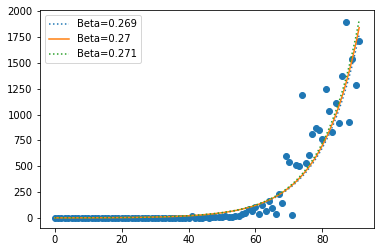

In [8]:
n_cases = newCases(india)[:92]
print("Number of days: ", len(n_cases))
t = np.array([x for x in range(len(n_cases))])

ret = odeint(deriv, y0, t, args=(beta_int[0], gamma, epsilon))
S, E, I, R = ret.T
cmu0 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[1], gamma, epsilon))
S, E, I, R = ret.T
cmu1 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[2], gamma, epsilon))
S, E, I, R = ret.T
cmu2 = p*I*N

t = [day for day in range(len(n_cases))]
plt.scatter(t, n_cases)
plt.plot(t, cmu0, label="Beta="+str(beta_int[0]), linestyle=":")
plt.plot(t, cmu1, label="Beta="+str(beta_int[1]))
plt.plot(t, cmu2, label="Beta="+str(beta_int[2]), linestyle=":")
plt.legend()
plt.show()



Beta= 0.269 : Max infected -  23002014.846665196 Days -  (array([217]),) Total -  1226091792.6750267
Beta= 0.27 : Max infected -  22884246.38765742 Days -  (array([218]),) Total -  1224735383.0855777
Beta= 0.271 : Max infected -  23119537.898805477 Days -  (array([216]),) Total -  1227429781.16374


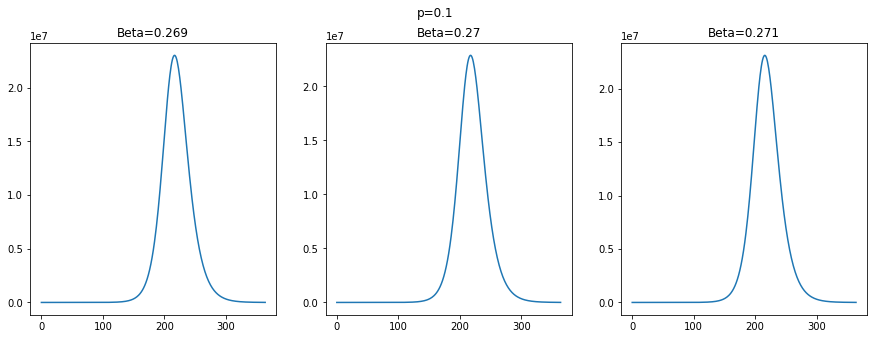

In [9]:
p = 0.1
E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

def deriv(y, t, beta, gamma, epsilon):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = (beta * S * I) - (epsilon * E)
    dIdt = (epsilon * E) - (gamma * I)
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0

t = np.array([x for x in range(365)])

ret = odeint(deriv, y0, t, args=(beta_int[0], gamma, epsilon))
S, E, I, R = ret.T
cmu1 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[1], gamma, epsilon))
S, E, I, R = ret.T
cmu0 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[2], gamma, epsilon))
S, E, I, R = ret.T
cmu2 = p*I*N

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('p=0.1')

ax1.set_title('Beta='+str(beta_int[0]))
ax1.plot(t, cmu0)

ax2.set_title('Beta='+str(beta_int[1]))
ax2.plot(t, cmu1)

ax3.set_title('Beta='+str(beta_int[2]))
ax3.plot(t, cmu2)
fig.show()



print("Beta=", beta_int[0], ": Max infected - ", max(cmu0), "Days - ", np.where(cmu0 == max(cmu0)), "Total - ", np.sum(cmu0))
print("Beta=", beta_int[1], ": Max infected - ", max(cmu1), "Days - ", np.where(cmu1 == max(cmu1)), "Total - ", np.sum(cmu1))
print("Beta=", beta_int[2], ": Max infected - ", max(cmu2), "Days - ", np.where(cmu2 == max(cmu2)), "Total - ", np.sum(cmu2))

Beta= 0.269 : Total infected -  2300442.9968265365 Days -  (array([191]),) Total -  122614858.30073607
Beta= 0.27 : Total infected -  2288369.708815885 Days -  (array([192]),) Total -  122479810.53952742
Beta= 0.271 : Total infected -  2312330.990867192 Days -  (array([190]),) Total -  122748144.82557207


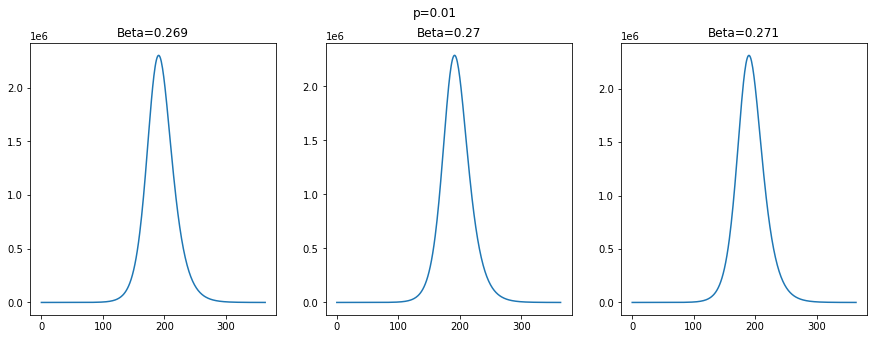

In [10]:
p = 0.01
E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

# Initial conditions vector
y0 = S0, E0, I0, R0
t = np.array([x for x in range(365)])

ret = odeint(deriv, y0, t, args=(beta_int[0], gamma, epsilon))
S, E, I, R = ret.T
cmu1 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[1], gamma, epsilon))
S, E, I, R = ret.T
cmu0 = p*I*N

ret = odeint(deriv, y0, t, args=(beta_int[2], gamma, epsilon))
S, E, I, R = ret.T
cmu2 = p*I*N

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('p=0.01')

ax1.set_title('Beta='+str(beta_int[0]))
ax1.plot(t, cmu0)

ax2.set_title('Beta='+str(beta_int[1]))
ax2.plot(t, cmu1)

ax3.set_title('Beta='+str(beta_int[2]))
ax3.plot(t, cmu2)
fig.show()

print("Beta=", beta_int[0], ": Total infected - ", max(cmu0), "Days - ", np.where(cmu0 == max(cmu0)), "Total - ", np.sum(cmu0))
print("Beta=", beta_int[1], ": Total infected - ", max(cmu1), "Days - ", np.where(cmu1 == max(cmu1)), "Total - ", np.sum(cmu1))
print("Beta=", beta_int[2], ": Total infected - ", max(cmu2), "Days - ", np.where(cmu2 == max(cmu2)), "Total - ", np.sum(cmu2))

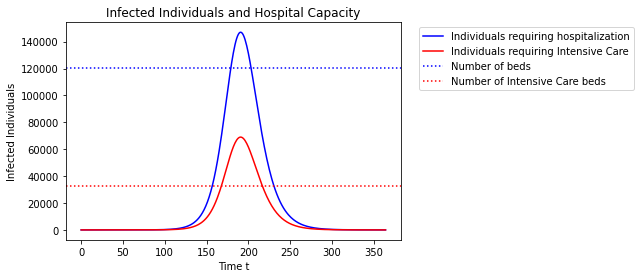

Overrun hospital beds by: 26894.30749721569
Overrun intensive care beds by: 36651.2899047961


In [11]:
p = 0.01
E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

# Initial conditions vector
y0 = S0, E0, I0, R0
t = np.array([x for x in range(365)])

ret = odeint(deriv, y0, t, args=(beta_int[1], gamma, epsilon))
S, E, I, R = ret.T
cmu0 = p*I*N

hosp_rate = 0.0639
icu_rate = 0.03

# https://www.theweek.in/news/india/2020/05/20/covid-19-639-of-total-active-cases-needed-hospital-support.html
cmu_hosp = hosp_rate * cmu0
cmu_icu = icu_rate * cmu0

# https://www.newindianexpress.com/nation/2020/jun/12/india-may-run-out-of-icu-beds-for-covid-19-patients-by-july-end-study-2155757.html
bed_hosp = 120104
icu_hosp = 32362

plt.title('Infected Individuals and Hospital Capacity')
# plt.plot(t, cmu0)
plt.plot(t, cmu_hosp,  color="blue", label="Individuals requiring hospitalization")
plt.plot(t, cmu_icu, color="red", label="Individuals requiring Intensive Care")
plt.axhline(bed_hosp, color="blue", linestyle=":", label="Number of beds")
plt.axhline(icu_hosp, color="red", linestyle=":", label="Number of Intensive Care beds")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Time t")
plt.ylabel("Infected Individuals")
plt.show()

print("Overrun hospital beds by:", max(cmu_hosp)-bed_hosp)
print("Overrun intensive care beds by:", max(cmu_icu)-icu_hosp)


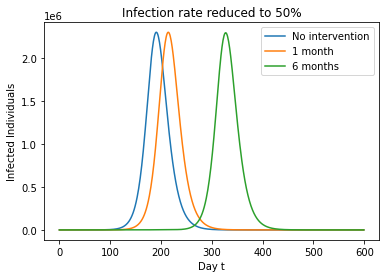

No intervention: Max infected -  2300442.9968265365 Days -  (array([191]),) Total -  122616106.95029362
1 month: Max infected -  2300434.2160161957 Hospitalized -  146997.7464034349 ICU -  69013.02648048587 Days -  (array([214]),) Total -  122615861.98726271
6 month: Max infected -  2294534.701457577 Hospitalized -  146620.76742313916 ICU -  68836.04104372731 Days -  (array([327]),) Total -  122592569.19705008


In [12]:
p = 0.01
E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

# time period between first case and complete lockdown
n_cases_len = 55
'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

# t = [i for i in range(550)]
t = [i for i in range(600)]


def beta_split(original_beta, n_beta, time_period):
  t_pre = [k for k in range(n_cases_len)]
  t_time_period = [x for x in range(n_cases_len, n_cases_len+time_period)]
  t_rem = [y for y in range(n_cases_len+time_period, (600))]

  ret = odeint(deriv, y0, t_pre, args=(original_beta, gamma, epsilon))
  S, E, I, R = ret.T
  cmu0 = p*I*N

  y0_iter1 = S[-1], E[-1], I[-1], R[-1]
  ret = odeint(deriv, y0_iter1, t_time_period, args=(n_beta, gamma, epsilon))
  S, E, I, R = ret.T
  cmu1 = p*I*N

  y0_iter2 = S[-1], E[-1], I[-1], R[-1]
  ret = odeint(deriv, y0_iter2, t_rem, args=(original_beta, gamma, epsilon))
  S, E, I, R = ret.T
  cmu2 = p*I*N

  return(np.concatenate((cmu0, cmu1, cmu2), axis=0))

beta_50_reduced = round(0.50*0.27, 3)

# Initial conditions vector
y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, t, args=(0.27, gamma, epsilon))
S, E, I, R = ret.T
cmu = p*I*N

month_1 = beta_split(0.27, beta_50_reduced, 30)
month_6 = beta_split(0.27, beta_50_reduced, 180)

year_1 = beta_split(0.27, beta_50_reduced, 365)
year_1_5 = beta_split(0.27, beta_50_reduced, 545)

plt.title("Infection rate reduced to 50%")
plt.ylabel("Infected Individuals")
plt.xlabel("Day t")
plt.plot(t, cmu, label="No intervention")
plt.plot(t, month_1, label="1 month")
plt.plot(t, month_6, label="6 months")
# plt.plot(t, year_1, label="1 year")
# plt.plot(t, year_1_5, label="1.5 years")
plt.legend()
plt.show()

print("No intervention: Max infected - ", max(cmu), "Days - ", np.where(cmu == max(cmu)), "Total - ", np.sum(cmu))
print("1 month: Max infected - ", max(month_1), "Hospitalized - ", max(month_1)*hosp_rate, "ICU - ", max(month_1)*icu_rate, "Days - ", np.where(month_1 == max(month_1)), "Total - ", np.sum(month_1))
print("6 month: Max infected - ", max(month_6), "Hospitalized - ", max(month_6)*hosp_rate, "ICU - ", max(month_6)*icu_rate, "Days - ", np.where(month_6 == max(month_6)), "Total - ", np.sum(month_6))

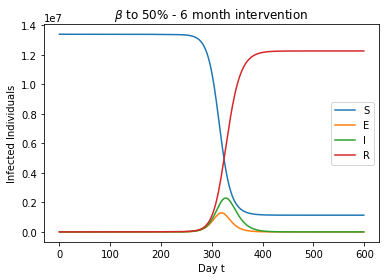

In [25]:
p = 0.01
E0 = 0
I0 = (1/(p*N))
R0 = 0

S0 = 1 - E0 - I0 - R0

# time period between first case and complete lockdown
n_cases_len = 55
'''
beta - infection rate
gamma - removal rate (prev. studies)
epsilon - onset rate (prev. studies)
'''
gamma, epsilon = 0.1, 0.2

# t = [i for i in range(550)]
t = [i for i in range(600)]


def beta_split_exp(original_beta, n_beta, time_period):
  t_pre = [k for k in range(n_cases_len)]
  t_time_period = [x for x in range(n_cases_len, n_cases_len+time_period)]
  t_rem = [y for y in range(n_cases_len+time_period, (600))]

  ret = odeint(deriv, y0, t_pre, args=(original_beta, gamma, epsilon))
  S, E, I, R = ret.T
  s_cmu0 = p*S*N
  e_cmu0 = p*E*N
  i_cmu0 = p*I*N
  r_cmu0 = p*R*N

  y0_iter1 = S[-1], E[-1], I[-1], R[-1]
  ret = odeint(deriv, y0_iter1, t_time_period, args=(n_beta, gamma, epsilon))
  S, E, I, R = ret.T
  s_cmu1 = p*S*N
  e_cmu1 = p*E*N
  i_cmu1 = p*I*N
  r_cmu1 = p*R*N

  y0_iter2 = S[-1], E[-1], I[-1], R[-1]
  ret = odeint(deriv, y0_iter2, t_rem, args=(original_beta, gamma, epsilon))
  S, E, I, R = ret.T
  s_cmu2 = p*S*N
  e_cmu2 = p*E*N
  i_cmu2 = p*I*N
  r_cmu2 = p*R*N

  return([np.concatenate((s_cmu0, s_cmu1, s_cmu2), axis=0), 
          np.concatenate((e_cmu0, e_cmu1, e_cmu2), axis=0), 
          np.concatenate((i_cmu0, i_cmu1, i_cmu2), axis=0), 
          np.concatenate((r_cmu0, r_cmu1, r_cmu2), axis=0)])

beta_50_reduced = round(0.50*0.27, 3)

# Initial conditions vector
y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, t, args=(0.27, gamma, epsilon))
S, E, I, R = ret.T
cmu = p*I*N

# month_1 = beta_split_exp(0.27, beta_50_reduced, 30)
month_6 = beta_split_exp(0.27, beta_50_reduced, 180)

# year_1 = beta_split_exp(0.27, beta_50_reduced, 365)
year_1_5 = beta_split_exp(0.27, beta_50_reduced, 545)

plt.title(r"$\beta$ to 50% - 6 month intervention")
plt.ylabel("Infected Individuals")
plt.xlabel("Day t")
plt.plot(t, month_6[0], label="S")
plt.plot(t, month_6[1], label="E")
plt.plot(t, month_6[2], label="I")
plt.plot(t, month_6[3], label="R")

# plt.plot(t, year_1_5[0], label="S")
# plt.plot(t, year_1_5[1], label="E")
# plt.plot(t, year_1_5[2], label="I")
# plt.plot(t, year_1_5[3], label="R")

# plt.plot(t, year_1, label="1 year")
# plt.plot(t, year_1_5, label="1.5 years")
plt.legend()
plt.show()

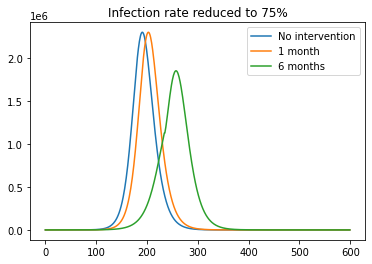

No intervention: Max infected -  2300442.9968265365 Days -  (array([191]),) Total -  122616106.95029362
1 month: Max infected -  2300182.1238382943 Hospitalized -  146981.637713267 ICU -  69005.46371514883 Days -  (array([203]),) Total -  122616206.14208607
6 months: Max infected -  1852041.8400387615 Hospitalized -  118345.47357847686 ICU -  55561.25520116284 Days -  (array([257]),) Total -  121431975.4321057


In [14]:
beta_75_reduced = round(0.75*0.27, 3)

# Initial conditions vector
y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, t, args=(0.27, gamma, epsilon))
S, E, I, R = ret.T
cmu = p*I*N

month_1 = beta_split(0.27, beta_75_reduced, 30)
month_6 = beta_split(0.27, beta_75_reduced, 180)

plt.title("Infection rate reduced to 75%")
plt.plot(t, cmu, label="No intervention")
plt.plot(t, month_1, label="1 month")
plt.plot(t, month_6, label="6 months")
plt.legend()
plt.show()


print("No intervention: Max infected - ", max(cmu), "Days - ", np.where(cmu == max(cmu)), "Total - ", np.sum(cmu))
print("1 month: Max infected - ", max(month_1), "Hospitalized - ", max(month_1)*hosp_rate, "ICU - ", max(month_1)*icu_rate, "Days - ", np.where(month_1 == max(month_1)), "Total - ", np.sum(month_1))
print("6 months: Max infected - ", max(month_6), "Hospitalized - ", max(month_6)*hosp_rate, "ICU - ", max(month_6)*icu_rate, "Days - ", np.where(month_6 == max(month_6)), "Total - ", np.sum(month_6))

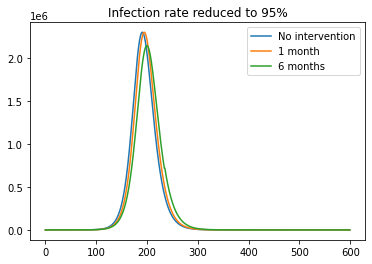

No intervention: Max infected -  2300442.9968265365 Days -  (array([191]),) Total -  122616106.95029362
1 month: Max infected -  2300014.2289377274 Hospitalized -  146970.90922912076 ICU -  69000.42686813182 Days -  (array([195]),) Total -  122616873.6568905
6 months: Max infected -  2144568.189915324 Hospitalized -  137037.9073355892 ICU -  64337.04569745972 Days -  (array([200]),) Total -  121649922.20329426


In [15]:
beta_95_reduced = round(0.95*0.27, 3)

# Initial conditions vector
y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, t, args=(0.27, gamma, epsilon))
S, E, I, R = ret.T
cmu = p*I*N

month_1 = beta_split(0.27, beta_95_reduced, 30)
month_6 = beta_split(0.27, beta_95_reduced, 180)

plt.title("Infection rate reduced to 95%")
plt.plot(t, cmu, label="No intervention")
plt.plot(t, month_1, label="1 month")
plt.plot(t, month_6, label="6 months")
plt.legend()
plt.show()


print("No intervention: Max infected - ", max(cmu), "Days - ", np.where(cmu == max(cmu)), "Total - ", np.sum(cmu))
print("1 month: Max infected - ", max(month_1), "Hospitalized - ", max(month_1)*hosp_rate, "ICU - ", max(month_1)*icu_rate, "Days - ", np.where(month_1 == max(month_1)), "Total - ", np.sum(month_1))
print("6 months: Max infected - ", max(month_6), "Hospitalized - ", max(month_6)*hosp_rate, "ICU - ", max(month_6)*icu_rate, "Days - ", np.where(month_6 == max(month_6)), "Total - ", np.sum(month_6))